In [4]:
from models import MLP, LinearProbe, NonLinearProbe
from datasets import NumericDataset, ClassificationDataset, NumericDatasetTransformer
from utils import vis_numerical_input, get_xor_bit, hook_layer_activations
from trainers import train_mlp, test_mlp
from torch.utils.data import DataLoader
import torch
import numpy as np
import lovely_tensors as lt
import torch.optim as optim

# some code to reload modules when they change
from IPython import get_ipython
ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
# %config Completer.use_jedi = False


# seed for reproducibility

seed = 0
torch.manual_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_1948029/4087191573.py:14: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_1948029/4087191573.py:15: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
config = {
    'modulo': 113,
    'MLP_hidden_layers': [1024, 1024, 1024],
    'batch_size': 1000,
    'lr': 0.001,
    'epochs': 30,
    'mlp_weight_decay': 0,
    'mlp_train_test_split': 0.8,
    'shuffle': False
}

# Define train and test splits of numerical data

In [4]:
dataset = NumericDataset(config['modulo'])

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=config['shuffle'])

# train/load in pre-trained MLP

In [5]:
mlp = MLP(
    input_dim=230,
    output_dim=114,
    hidden_dims=config['MLP_hidden_layers'],
)


# mlp = train_mlp(config, train_loader, mlp)

# test_mlp(config, test_loader, mlp)

# # save mlp

# torch.save(mlp.state_dict(), 'mlp.pth')

# load mlp

mlp.load_state_dict(torch.load('mlp.pth'))

# test mlp
test_mlp(config, test_loader, mlp)




Test accuracy: 0.9877642913077526


# Train linear probe on each layer

### Experiment 1

The issue with this experiment is that it trains a linear probe to find a direction where the dot product along that direction results in a very negative number for XOR=0 and very postive for XOR=1. However, this seems like the wrong objective because activations are always postive, so even if there was a one-dim direction along which one could learn a zero-dim linear SVM that could classifiy the XOR bit, then we still couldn't get very good loss becuase 

NOTE: this is different to how they did it in the othello-gpt paper, seems like they would have used a [1024,2] probe under the assumption that XOR_IS_0 and XOR_IS_1 are linearly represented in the data, and increasing the activations along the direction of these features makes the model more likely to be XOR_IS_0 or XOR_IS_1. The relative strengh of these two features can be used to find a prob of in either state using a softmax over the two output logits. This makes a lot more sense to me than whatever the hell is going on below... I'm pretty sure however that the fact that we can pick up on the XOR bit using the below then this garentees that the Othello-GPT method should work here too? Idk... I might just train an SAE under this assumption...

Update: I'm a lil confused here, I guess it makes sense how a one dim linear probe could pick up on if the activations for XOR 0 was [1,2] and 1 was [2,1] and the linear probe was [-1,1] (in a 2-dim subspace of the 1024 activation space), then I guess the two features are XOR_IS_0 and XOR_IS_1... A source of this confusion is that the linear probe has to contain negative values and therefore not be aligned with any features in activation space (because all activations must be positve). Do the results here support a picture where the representation is in fact linearly represented in the activations or is there some quirk here where the feature isn't linear but can be classified by this probe anyway?

Note: Finding a linear direction we can intervene on would be cool to prove some shit

Note: Worth just moving onto SAEs at this point tbh, I've seen enough...



In [5]:
import matplotlib.pyplot as plt


xor_bits = get_xor_bit(train_dataset.dataset.data[0])

linear_probe_losses_per_layer = {}
linear_probes = {}

for layer_index in range(0,6):

    activations = hook_layer_activations(mlp, train_dataset.dataset.data[0], layer_index)

    dataset_predict_xor_from_activatoins = ClassificationDataset(activations, xor_bits)

    linear_probe_dataloader = DataLoader(dataset_predict_xor_from_activatoins, batch_size=config['batch_size'], shuffle=config['shuffle'])

    probe = LinearProbe(1024, 1)
    probe_optim = optim.Adam(probe.parameters(), lr=config['lr'])
    criterion = torch.nn.BCEWithLogitsLoss()

    linear_probe_losses_per_layer[f'layer_{layer_index}'] = []

    for epoch in range(40):
        for i, (activations, target_xors) in enumerate(linear_probe_dataloader):
            activations = activations.float()
            target_xors = target_xors.float()

            pred_xor = probe(activations).squeeze()
            loss = criterion(pred_xor, target_xors)
            probe_optim.zero_grad()
            loss.backward()
            probe_optim.step()
        linear_probe_losses_per_layer[f'layer_{layer_index}'].append(loss.item())
        
    linear_probes[f'layer_{layer_index}'] = probe



In [6]:
# test accuracy of each probe
for layer_index in range(0,6):
    
    activations = hook_layer_activations(mlp, test_dataset.dataset.data[0], layer_index)

    dataset_predict_xor_from_activatoins = ClassificationDataset(activations, xor_bits)

    linear_probe_dataloader = DataLoader(dataset_predict_xor_from_activatoins, batch_size=config['batch_size'], shuffle=config['shuffle'])

    count = 0
    for i, (activations, target_xors) in enumerate(linear_probe_dataloader):
        activations = activations.float()
        target_xors = target_xors.float()

        pred_xor = linear_probes[f'layer_{layer_index}'](activations).squeeze()
        pred_xor = torch.sigmoid(pred_xor)
        pred_xor = torch.round(pred_xor)
        assert pred_xor.shape == target_xors.shape
        count += torch.sum(pred_xor == target_xors).item()
    print(f'Layer {layer_index} accuracy: {count / len(test_dataset.dataset.data[0])}')


Layer 0 accuracy: 0.5
Layer 1 accuracy: 0.9999412639987469
Layer 2 accuracy: 0.9782676795363772
Layer 3 accuracy: 0.9574751350928029
Layer 4 accuracy: 0.8112812279739995
Layer 5 accuracy: 0.5743401989192576


In [7]:


input, _ = train_dataset[:10000]

target_xor = get_xor_bit(input)

activations = hook_layer_activations(mlp, input, layer_index=1)

probe_output = linear_probes['layer_1'](activations.float()).squeeze()

print(probe_output[:10])
print(target_xor[:10])

count = torch.sum((probe_output > 0) == target_xor).item()

total = len(target_xor)
print((probe_output > 0).shape)

print('count', count)
print('total', total)
print('accuracy', count/total)



tensor([ 3.1643,  1.9144, -2.9222,  2.2082,  2.5349,  3.1304, -2.2030,  1.1027,
         3.2726, -2.1435], grad_fn=<SliceBackward0>)
tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 0])
torch.Size([10000])
count 10000
total 10000
accuracy 1.0


## Plotting loss vs epochs for linear probes

Clearly the XOR bit is linearly represented in layer 2

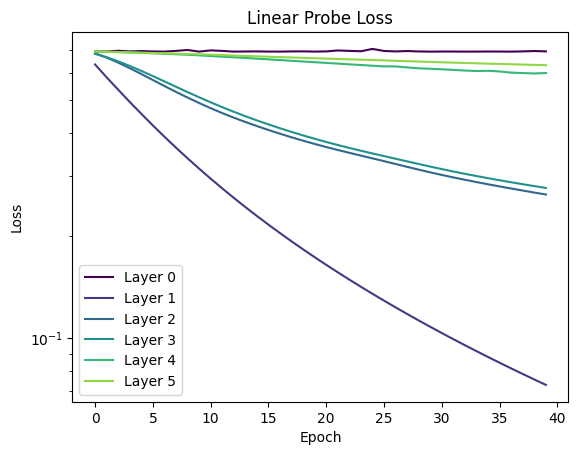

In [8]:
import matplotlib.pyplot as plt
import numpy as np

num_hidden_layers = 6

# Create a color map
cmap = plt.get_cmap('viridis')
colors = [cmap(i / num_hidden_layers) for i in range(num_hidden_layers)]

# Plot the losses per layer with the corresponding color
for layer_index in range(num_hidden_layers):
    plt.plot(linear_probe_losses_per_layer[f'layer_{layer_index}'], color=colors[layer_index], label=f'Layer {layer_index}')

plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Probe Loss')
plt.show()


## Visualizing the linear probe output

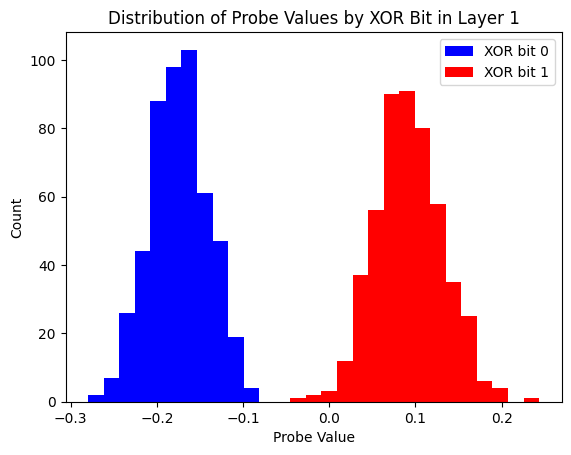

In [9]:
import matplotlib.pyplot as plt
import numpy as np

layer_index = 1

X_batch, y_batch = next(iter(train_loader))



X_batch = X_batch[:1000]
y_batch = y_batch[:1000]

activations_for_batch = hook_layer_activations(mlp, X_batch, layer_index)

probe = linear_probes[f'layer_{layer_index}']


# normalize the probe weights
probe_weights = probe.linear.weight.detach().numpy().squeeze()
norm = np.linalg.norm(probe_weights)
probe_weights /= norm

probe.linear.weight.data = torch.tensor(probe_weights).float().unsqueeze(0)

xor_pred = probe(activations_for_batch).detach().numpy().squeeze()

xor_bits_for_batch = get_xor_bit(X_batch).detach().numpy().squeeze()

# Create bins for the histogram
bins = np.linspace(xor_pred.min(), xor_pred.max(), 30)

# Separate probe values based on XOR bit
probe_values_0 = xor_pred[xor_bits_for_batch == 0]
probe_values_1 = xor_pred[xor_bits_for_batch == 1]

# Plot stacked histogram
plt.hist([probe_values_0, probe_values_1], bins=bins, stacked=True, color=['blue', 'red'], label=['XOR bit 0', 'XOR bit 1'])
plt.xlabel('Probe Value')
plt.ylabel('Count')
plt.title(f'Distribution of Probe Values by XOR Bit in Layer {layer_index}')
plt.legend()
plt.show()



In [10]:
# get the norm of the weights of the probe

layer_index = 1
probe = linear_probes[f'layer_{layer_index}']

weights = probe.linear.weight.detach().numpy().squeeze()

norm = np.linalg.norm(weights)

print(norm)



19.1526


# Train non-linear probe on each layer

In [23]:

xor_bits = get_xor_bit(train_dataset.dataset.data[0])

non_linear_probe_losses_per_layer = {}
non_linear_probes = {}

for layer_index in range(0,6):

    activations = hook_layer_activations(mlp, train_dataset.dataset.data[0], layer_index)

    dataset_predict_xor_from_activatoins = ClassificationDataset(activations, xor_bits)

    non_linear_probe_dataloader = DataLoader(dataset_predict_xor_from_activatoins, batch_size=config['batch_size'], shuffle=config['shuffle'])

    probe = NonLinearProbe(1024, 1)
    probe_optim = optim.Adam(probe.parameters(), lr=config['lr'])
    criterion = torch.nn.BCEWithLogitsLoss()

    non_linear_probe_losses_per_layer[f'layer_{layer_index}'] = []

    for epoch in range(40):
        for i, (activations, target_xors) in enumerate(non_linear_probe_dataloader):
            activations = activations.float()
            target_xors = target_xors.float()

            pred_xor = probe(activations).squeeze()
            loss = criterion(pred_xor, target_xors)
            probe_optim.zero_grad()
            loss.backward()
            probe_optim.step()
        non_linear_probe_losses_per_layer[f'layer_{layer_index}'].append(loss.item())
        
    non_linear_probes[f'layer_{layer_index}'] = probe

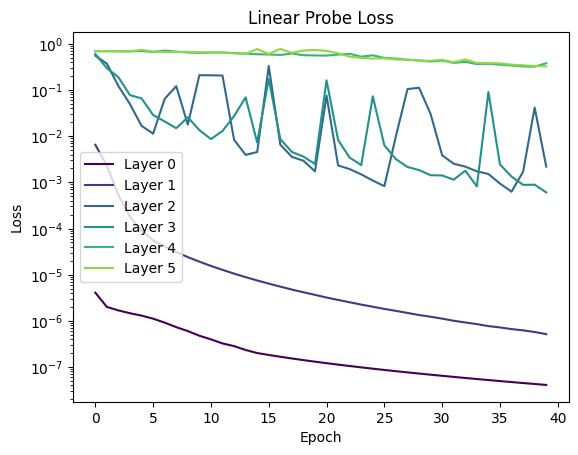

In [24]:
import matplotlib.pyplot as plt
import numpy as np

num_hidden_layers = 6

# Create a color map
cmap = plt.get_cmap('viridis')
colors = [cmap(i / num_hidden_layers) for i in range(num_hidden_layers)]

# Plot the losses per layer with the corresponding color
for layer_index in range(num_hidden_layers):
    plt.plot(non_linear_probe_losses_per_layer[f'layer_{layer_index}'], color=colors[layer_index], label=f'Layer {layer_index}')

plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Probe Loss')
plt.show()


In [25]:
# test accuracy of each probe
for layer_index in range(0,6):
    activations = hook_layer_activations(mlp, test_dataset.dataset.data[0], layer_index)

    dataset_predict_xor_from_activatoins = ClassificationDataset(activations, xor_bits)

    non_linear_probe_dataloader = DataLoader(dataset_predict_xor_from_activatoins, batch_size=config['batch_size'], shuffle=config['shuffle'])

    count = 0
    for i, (activations, target_xors) in enumerate(non_linear_probe_dataloader):
        activations = activations.float()
        target_xors = target_xors.float()

        pred_xor = non_linear_probes[f'layer_{layer_index}'](activations).squeeze()
        pred_xor = torch.sigmoid(pred_xor)
        pred_xor = torch.round(pred_xor)
        assert pred_xor.shape == target_xors.shape
        count += torch.sum(pred_xor == target_xors).item()
    print(f'Layer {layer_index} accuracy: {count / len(test_dataset.dataset.data[0])}')


Layer 0 accuracy: 1.0
Layer 1 accuracy: 1.0
Layer 2 accuracy: 0.9956926932414442
Layer 3 accuracy: 0.9967499412639987
Layer 4 accuracy: 0.8947450857545618
Layer 5 accuracy: 0.9006382645469496


# Train a linear probe 1024 * 2 like in Othello paper with softmax <3

I think this is more principled, we come up with features, we check if we can detect them, we viz their values, and check if we can intervene on them.

Also the vectors can be more readily interpreted, because the best way to increase XOR 1-ness is by aligning one of the vectors with the direction that encodes the feature.

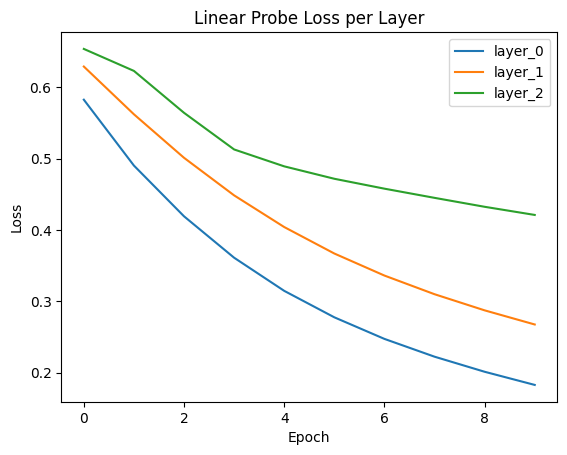

In [6]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
 
xor_bits = get_xor_bit(train_dataset.dataset.data[0])

linear_probe_losses_per_layer = {}
linear_probes = {}
num_hidden_layers = len(mlp.layers) - 1 # -1 because we don't probe the output layer

for layer_index in range(num_hidden_layers):

    activations = hook_layer_activations(mlp, train_dataset.dataset.data[0], layer_index)

    dataset_predict_xor_from_activatoins = ClassificationDataset(activations, xor_bits)

    linear_probe_dataloader = DataLoader(dataset_predict_xor_from_activatoins, batch_size=config['batch_size'], shuffle=config['shuffle'])

    probe = LinearProbe(1024, 2)  # Change output dim to 2
    probe_optim = optim.Adam(probe.parameters(), lr=config['lr'])
    criterion = torch.nn.CrossEntropyLoss()  # Change to CrossEntropyLoss

    linear_probe_losses_per_layer[f'layer_{layer_index}'] = []

    for epoch in range(10):
        for i, (activations, target_xors) in enumerate(linear_probe_dataloader):
            activations = activations.float()
            target_xors = target_xors.long()  # CrossEntropyLoss expects targets to be of type long

            pred_xor = probe(activations)

            loss = criterion(pred_xor, target_xors)
            probe_optim.zero_grad()
            loss.backward()
            probe_optim.step()
        linear_probe_losses_per_layer[f'layer_{layer_index}'].append(loss.item())
        
    linear_probes[f'layer_{layer_index}'] = probe

# Plotting the loss curves
for layer, losses in linear_probe_losses_per_layer.items():
    plt.plot(losses, label=layer)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Linear Probe Loss per Layer')
plt.show()


Something to note here is that the pre-activations can also be probed, and accuracies are pretty high for the probes trained on these.

### find accuracy for the 1024 * 2 linear probe model

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming get_xor_bit, hook_layer_activations, ClassificationDataset, and other necessary components are defined elsewhere

xor_bits_test = get_xor_bit(test_dataset.dataset.data[0])

linear_probe_accuracies_per_layer = {}

for layer_index in range(num_hidden_layers):

    # Extract activations from the test dataset
    activations_test = hook_layer_activations(mlp, test_dataset.dataset.data[0], layer_index)

    # Create a dataset for the test activations and corresponding XOR bits
    dataset_predict_xor_from_activations_test = ClassificationDataset(activations_test, xor_bits_test)

    # Create a DataLoader for the test dataset
    linear_probe_test_dataloader = DataLoader(dataset_predict_xor_from_activations_test, batch_size=config['batch_size'], shuffle=False)

    # Get the corresponding trained probe for the current layer
    probe = linear_probes[f'layer_{layer_index}']

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for activations, target_xors in linear_probe_test_dataloader:
            activations = activations.float()
            target_xors = target_xors.long()

            # Make predictions
            pred_xor_logits = probe(activations)
            pred_xors = torch.argmax(pred_xor_logits, dim=1)

            # Calculate the number of correct predictions
            correct_predictions += (pred_xors == target_xors).sum().item()
            total_predictions += target_xors.size(0)

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    print(f'Layer {layer_index} accuracy: {accuracy}')

Layer 0 accuracy: 0.9997258986608192
Layer 1 accuracy: 0.9946941812201425
Layer 2 accuracy: 0.7703422351006344


In [8]:
print(mlp)

(a+b) % 113 + xor (x,y)

MLP(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=230, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=1024, out_features=114, bias=True)
  )
)



## Plot the values of the output logits to vizualize feature values for XOR 0 and 1

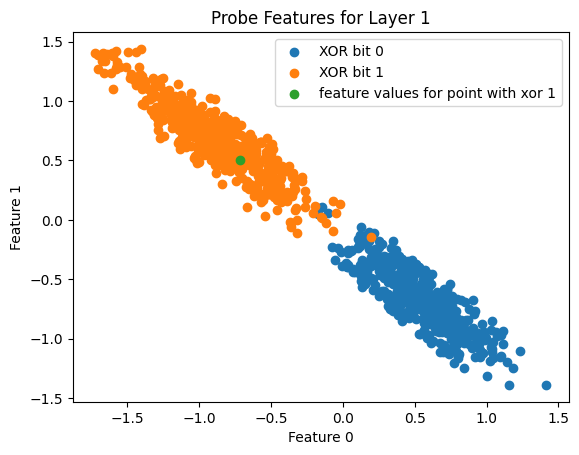

In [9]:
layer_index = 1
single_point_index = 20
probe = linear_probes[f'layer_{layer_index}']

X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch[:1000]
y_batch = y_batch[:1000]


xor_bits_for_batch = get_xor_bit(X_batch)
activations_for_batch = hook_layer_activations(mlp, X_batch, layer_index)

feature_values = probe(activations_for_batch)


X_single_point = X_batch[single_point_index].unsqueeze(0)
xor_bit_single_point = get_xor_bit(X_single_point)
activation_single_point = hook_layer_activations(mlp, X_single_point, layer_index)
feature_values_single_point = probe(activation_single_point)


feature_values_xor0 = feature_values[xor_bits_for_batch == 0]
feature_values_xor1 = feature_values[xor_bits_for_batch == 1]



# 2d scatter plaot

plt.scatter(feature_values_xor0[:, 0].detach().numpy(), feature_values_xor0[:, 1].detach().numpy(), label='XOR bit 0')
plt.scatter(feature_values_xor1[:, 0].detach().numpy(), feature_values_xor1[:, 1].detach().numpy(), label='XOR bit 1')
plt.scatter(feature_values_single_point[:, 0].detach().numpy(), feature_values_single_point[:, 1].detach().numpy(), label=f'feature values for point with xor {int(xor_bit_single_point)}')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title(f'Probe Features for Layer {layer_index}')
plt.legend()
plt.show()


Lets analyse the above graph, the points with xor=0 are in blue. Each point is (feature1,feature2) with blue having xor 0 and orange xor 1. For the xor0 feature1>feature2 as expected and for xor1 feature2>feature1 as expected.

Little bit weird how there is such a spread of values, would just expect two clusters of orange and blue points, instead seems like there is some constant ratio feature2_value = m * feature1_value.

In [10]:
for layer_index in range(num_hidden_layers):
    probe = linear_probes[f'layer_{layer_index}']

    feature_direction_1 = probe.linear.weight[0].detach()
    feature_direction_2 = probe.linear.weight[1].detach()

    # noramlize the weights

    feature_direction_1 /= torch.norm(feature_direction_1)
    feature_direction_2 /= torch.norm(feature_direction_2)

    # dot product of the the feature directions

    dot_product = torch.dot(feature_direction_1, feature_direction_2)

    print(f'Layer {layer_index} dot product: {dot_product :.4f}')


Layer 0 dot product: -0.9917
Layer 1 dot product: -0.9072
Layer 2 dot product: -0.2786


ok sweet they are almost perfectly opposites (except for the last hidden layer, which are surprisingly different), this makes a lot of sense that feature2_value = m * feature1_value for m = -1 since feature1_dir = - feature2_dir. This means the there is one direction where the information about the xor is kept? Ok not exactly sure how to interpret this but lets check if we can interven on this direction. 

A confusing part is that sometimes both features are positive and sometimes negative, but the activations are all postive. I think the explanation here is that the activation are positve but they can be decomposed into feature directions that can be negative. Eg we can say a positive coefficinet in front of the [-1,1] coeeficient means xor0 and neg means xor1, or equivelently we can say the feature for xor0 can be [1,-1] and xor1 be [-1,1]. This explains the above graph nicely

We can also conclude that the layers that have a better linear rep have a closer to -1 

### Lets try intervene on this direction
Lets do this by picking a datapoint, and adding enough of the opposite feature so it switches from blue cluster to orange above

===Data point info===
a:  8
b:  33
x:  0
y:  1
xor:  1
output:  42
xor of sample point: 1
pred output regular model: 42
pred output of intervened model: 93
predicted xor for single point intervened layer 0: 1
predicted xor for single point intervened layer 1: 1
predicted xor for single point intervened layer 2: 0
tensor([[-455.9557, -220.2595,  -61.2931,  -11.8966,    7.3502,   11.5393,
           -4.5442,   -2.9110,   16.4405,    4.5838]],
       grad_fn=<SliceBackward0>)
tensor([[-515.8377, -259.1493,  -76.0704,  -10.5969,   35.6376,   62.8308,
           36.7638,   16.5695,   34.5495,   19.8097]],
       grad_fn=<SliceBackward0>)


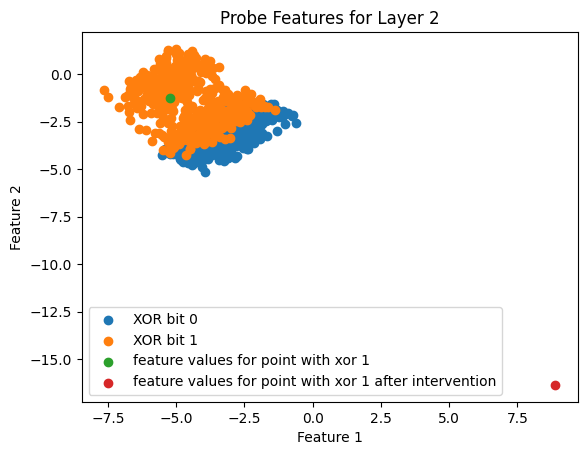

In [18]:
from utils import get_xor_steering_vector

mlp = MLP(
    input_dim=230,
    output_dim=114,
    hidden_dims=config['MLP_hidden_layers'],
)

mlp.load_state_dict(torch.load('mlp.pth'))


layer_index = 2

single_point_index = 501
coef = 10

# make the steering vector one of these if you want to use the linear directions learned by probe to intervene
# feature_direction_1 = linear_probes[f'layer_{layer_index}'].linear.weight[0].detach()
# feature_direction_2 = linear_probes[f'layer_{layer_index}'].linear.weight[1].detach()

probe = linear_probes[f'layer_{layer_index}']

def create_hook(V, coefficient):
    def hook_fn(module, input, output):
        return output + V * coefficient
    return hook_fn

probe = linear_probes[f'layer_{layer_index}']

X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch[:1000]
y_batch = y_batch[:1000]


xor_bits_for_batch = get_xor_bit(X_batch)
activations_for_batch = hook_layer_activations(mlp, X_batch, layer_index)
feature_values = probe(activations_for_batch)


X_single_point = X_batch[single_point_index].unsqueeze(0)
print('===Data point info===')
vis_numerical_input(X_single_point)
print('======================')
xor_bit_single_point = get_xor_bit(X_single_point)
print(f"xor of sample point: {int(xor_bit_single_point)}")
activation_single_point = hook_layer_activations(mlp, X_single_point, layer_index)
feature_values_single_point = probe(activation_single_point)
logits_single_point = mlp(X_single_point)
print(f'pred output regular model: {torch.argmax(logits_single_point)}')


mlp_intervened = mlp
steering_vector = get_xor_steering_vector(X_batch, mlp, layer_index)
hook = create_hook(steering_vector, coefficient=coef) # NOTE you may have to change sign in func depending on the xor bit
mlp_intervened.layers[layer_index].register_forward_hook(hook)
activations_for_single_point_intervened = hook_layer_activations(mlp_intervened, X_single_point, layer_index)
feature_values_single_point_intervened = probe(activations_for_single_point_intervened)
logits_single_point_intervened = mlp_intervened(X_single_point)
print(f'pred output of intervened model: {torch.argmax(logits_single_point_intervened)}')


activations_for_single_point_intervenved_layer0 = hook_layer_activations(mlp_intervened, X_single_point, 0)
feature_values_single_point_intervened_layer0 = linear_probes['layer_0'](activations_for_single_point_intervenved_layer0)
print(f'predicted xor for single point intervened layer 0: {torch.argmax(feature_values_single_point_intervened_layer0)}')

activations_for_single_point_intervenved_layer1 = hook_layer_activations(mlp_intervened, X_single_point, 1)
feature_values_single_point_intervened_layer1 = linear_probes['layer_1'](activations_for_single_point_intervenved_layer1)
print(f'predicted xor for single point intervened layer 1: {torch.argmax(feature_values_single_point_intervened_layer1)}')


activations_for_single_point_intervenved_layer2 = hook_layer_activations(mlp_intervened, X_single_point, 2)
feature_values_single_point_intervened_layer2 = linear_probes['layer_2'](activations_for_single_point_intervenved_layer2)
print(f'predicted xor for single point intervened layer 2: {torch.argmax(feature_values_single_point_intervened_layer2)}')

feature_values_xor0 = feature_values[xor_bits_for_batch == 0]
feature_values_xor1 = feature_values[xor_bits_for_batch == 1]


print(logits_single_point[:, :10])
print(logits_single_point_intervened[:, :10])

# 2d scatter plot

plt.scatter(feature_values_xor0[:, 0].detach().numpy(), feature_values_xor0[:, 1].detach().numpy(), label='XOR bit 0')
plt.scatter(feature_values_xor1[:, 0].detach().numpy(), feature_values_xor1[:, 1].detach().numpy(), label='XOR bit 1')
plt.scatter(feature_values_single_point[:, 0].detach().numpy(), feature_values_single_point[:, 1].detach().numpy(), label=f'feature values for point with xor {int(xor_bit_single_point)}')
plt.scatter(feature_values_single_point_intervened[:, 0].detach().numpy(), feature_values_single_point_intervened[:, 1].detach().numpy(), label=f'feature values for point with xor {int(xor_bit_single_point)} after intervention')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Probe Features for Layer {layer_index}')
plt.legend()
plt.show()



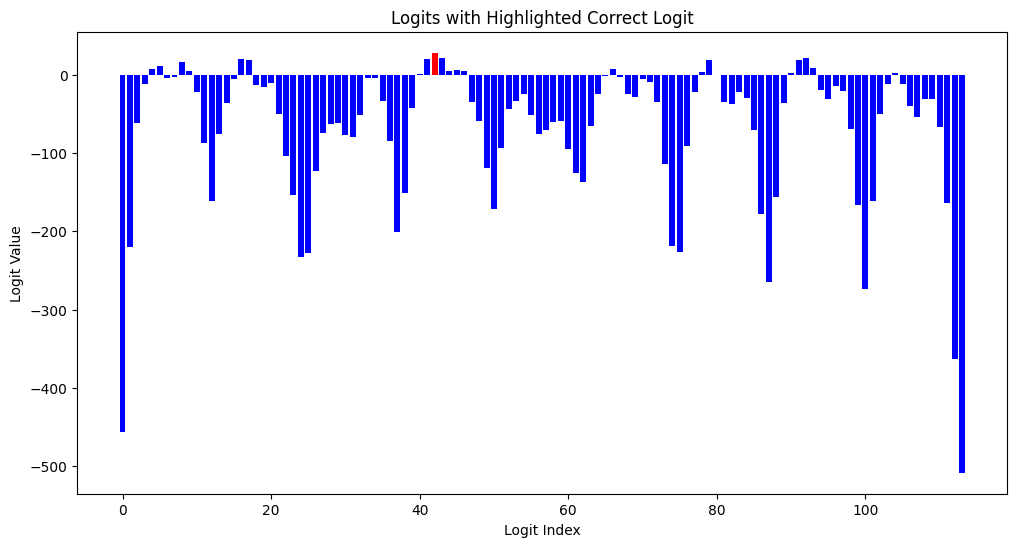

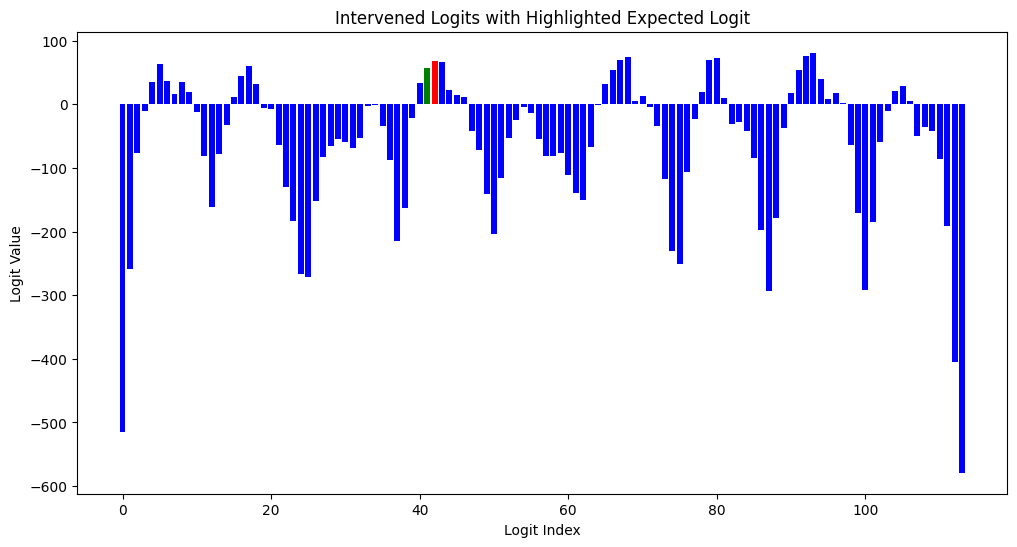

In [19]:
correct_logit_index = torch.argmax(logits_single_point).item()

if int(xor_bit_single_point) == 0:
    expected_answer = (torch.argmax(logits_single_point).item() + 1) % 114
else:
    expected_answer = (torch.argmax(logits_single_point).item() - 1) % 114


regular_logits_np = logits_single_point.detach().numpy().squeeze()
intervened_logits_np = logits_single_point_intervened.detach().numpy().squeeze()

# Plot the logits
plt.figure(figsize=(12, 6))
plt.bar(range(len(regular_logits_np)), regular_logits_np, color='blue')

# Highlight the correct logit
plt.bar(correct_logit_index, regular_logits_np[correct_logit_index], color='red')

# Adding labels and title
plt.xlabel('Logit Index')
plt.ylabel('Logit Value')
plt.title('Logits with Highlighted Correct Logit')

# Show the plot
plt.show()

# plot the intervened logits\
plt.figure(figsize=(12, 6))
plt.bar(range(len(intervened_logits_np)), intervened_logits_np, color='blue')

# Highlight the expected logit
plt.bar(expected_answer, intervened_logits_np[expected_answer], color='green')
# highlight the correct logit
plt.bar(correct_logit_index, intervened_logits_np[correct_logit_index], color='red')
# Adding labels and title
plt.xlabel('Logit Index')
plt.ylabel('Logit Value')
plt.title('Intervened Logits with Highlighted Expected Logit')
plt.show()


ok fixed, the hook was being added then removed. It seems like we can intervene on the xor to produce an output as if that xor was input to the model! 

The settings were:

layer_index = 2
single_point_index = 6

(ok so trying some other points didnt work, and becuase I was not setting a seed this is not very reproducible, but with such a high failure rate I'm not sure its relevant anyway)

Ok so unless there is a bug, it seems like the features we learned are not causal in the way we expected sadly. I am  now curious to see if we can find such a causal feature using activation averaging. After this assume MLPs are different and try all this on a transfomrer?

Ok lets try and see if steering vector is the same as the probing vector

In [43]:
steering_vector = get_xor_steering_vector(X_batch, mlp, layer_index=1)

feature_direction_1 = linear_probes['layer_1'].linear.weight[0].detach()
feature_direction_2 = linear_probes['layer_1'].linear.weight[1].detach()

# get the dot product of the normalized feature directions with the steering vector

feature_direction_1 /= torch.norm(feature_direction_1)
feature_direction_2 /= torch.norm(feature_direction_2)

steering_vector /= torch.norm(steering_vector)

steering_vector = get_xor_steering_vector(X_batch, mlp, layer_index=1)

dot_product_1 = torch.dot(feature_direction_1, steering_vector)
dot_product_2 = torch.dot(feature_direction_2, steering_vector)

print(f'Layer 1 feature direction 1 dot product with steering vector: {dot_product_1:.4f}')
print(f'Layer 1 feature direction 2 dot product with steering vector: {dot_product_2:.4f}')

Layer 1 feature direction 1 dot product with steering vector: 0.3874
Layer 1 feature direction 2 dot product with steering vector: -0.4004


Ok so not really, but I predict that there is a subspace where both the steering vector and learned feature direction are aligned (because intervening with steering vector leads to predictable change in value of features 0 and 1 of probe) and the of entries are not important. Eg if 3 dim act space and all xor info was encoded in first entry then there is some freedom to choose arbitrary entries for the other 2 entries.

Well in any case the intervention is not working, oh well, time to move onto this but with a transformer? Or maybe train an SAE of this? Transformer first methinks

In [2]:
from transformer_model import Transformer

In [3]:
# def cross_entropy_high_precision(logits, labels):
#     # Shapes: batch x vocab, batch
#     # Cast logits to float64 because log_softmax has a float32 underflow on overly 
#     # confident data and can only return multiples of 1.2e-7 (the smallest float x
#     # such that 1+x is different from 1 in float32). This leads to loss spikes 
#     # and dodgy gradients
#     logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
#     prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
#     loss = -torch.mean(prediction_logprobs)
#     return loss

# def full_loss(model, data):
#     # Take the final position only
#     logits = model(data)[:, -1]
#     labels = torch.tensor([(a+b)%113 + np.bitwise_xor(x, y) for a, b, x, y, _ in data]).to('cuda')
#     # print([(a+b)%113 + np.bitwise_xor(x,y) for a, b, x, y, _ in data])
#     return cross_entropy_high_precision(logits, labels)


# lr=1e-3 #@param
# weight_decay = 0.00001 #@param
# p=113 #@param
# d_model = 128 #@param
# num_epochs = 300 #@param
# # Stop training when test loss is <stopping_thresh


# num_layers = 3
# d_vocab = p+2
# n_ctx = 5
# d_mlp = 4*d_model
# num_heads = 4
# assert d_model % num_heads == 0
# d_head = d_model//num_heads
# act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# # batch_size = 512
# use_ln = False
# random_answers = np.random.randint(low=0, high=p, size=(p, p))


# model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
# model.to('cuda')


# dataset = []

# for a in range(p):
#     for b in range(p):
#         for x in range(2):
#             for y in range(2):
#                 dataset.append((a,b,x,y,113))


# dataset = torch.tensor(dataset).to('cuda')

# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# split = int(0.8*len(dataset))

# train_dataset = dataset[:split]
# test_dataset = dataset[split:]

# train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)


# accuracies = []
# losses = []
# for epoch in range(num_epochs):
#     for i, data in enumerate(train_loader):
#         data = data.cpu().numpy()
#         optimizer.zero_grad()
#         loss = full_loss(model, data)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch} loss: {loss.item()}')

#     true_answers = (data[:, 0] + data[:, 1])  % 113 + np.bitwise_xor(data[:, 2], data[:, 3])
#     logits = model(data)[:, -1]
#     predicted_answers = torch.argmax(logits, dim=-1)
#     true_answers = torch.tensor(true_answers).to('cuda')

#     correct = torch.sum(predicted_answers==true_answers)
#     print(f'Accuracy: {correct/len(data)}')
#     accuracies.append(correct/len(data))
#     losses.append(loss.item())

In [4]:
# import matplotlib.pyplot as plt
# # plot the accuracies


# accuracies = [a.cpu().numpy() for a in accuracies]
# plt.plot(accuracies)
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Epoch')
# plt.show()

# # plot the losses
# plt.plot(losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss vs Epoch')
# plt.show()


In [3]:
def test_model_accuracy(
    model: Transformer,
    test_dataset: np.ndarray
):
    assert type(test_dataset) == np.ndarray, 'test_dataset should be a numpy array'
    true_answers = (test_dataset[:, 0] + test_dataset[:, 1])  % 113 + np.bitwise_xor(test_dataset[:, 2], test_dataset[:, 3])
    true_answers = torch.tensor(true_answers).to('cuda')
    test_dataset_torch = torch.tensor(test_dataset).to('cuda')
    output_logits = model(test_dataset_torch)[:, -1]
    predicted_answers = torch.argmax(output_logits, dim=-1)

    correct = torch.sum(predicted_answers==true_answers)
    return correct/len(test_dataset)

# test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

# for i, data in enumerate(test_loader):
#     data = data.cpu().numpy()
#     logits = model(data)[:, -1]
#     print(torch.argmax(logits[0]))
#     print(f'true answer: {(data[0, 0] + data[0, 1]) % 113 + np.bitwise_xor(data[0, 2], data[0, 3])}')
#     true_answers = (data[:, 0] + data[:, 1])  % 113 + np.bitwise_xor(data[:, 2], data[:, 3])
#     logits = model(data)[:, -1]
#     predicted_answers = torch.argmax(logits, dim=-1)
#     true_answers = torch.tensor(true_answers).to('cuda')

#     correct = torch.sum(predicted_answers==true_answers)
#     print(f'Accuracy: {correct/len(data)}')
#     break    

In [6]:
# # save the model

# torch.save(model.state_dict(), 'transformer.pth')

In [26]:
lr=1e-3 #@param
weight_decay = 0.00001 #@param
p=113 #@param
d_model = 128 #@param
num_epochs = 300 #@param
# Stop training when test loss is <stopping_thresh
num_layers = 3
d_vocab = p+2
n_ctx = 5
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))

model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)

model.load_state_dict(torch.load('transformer.pth'))

print(model)

Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn): HookPoint()
        (hook_attn_pre): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)


In [8]:
import torch
import numpy as np


def get_resid_post_activations(
    model: Transformer,
    input: np.ndarray
) -> torch.Tensor:
    
    cache = {}
    model.cache_all(cache)

    dataset = np.array(input)
    _ = model(dataset)

    resid_post_activations = [cache[f'blocks.{i}.hook_resid_post'][:, -1] for i in range(len(model.blocks))]

    # clear the cache

    del cache

    return resid_post_activations


In [17]:
def train_probes_on_residual_streams(
    model: Transformer,
    raw_dataset: np.ndarray,
    num_blocks: int,
    epochs: int,
):
    
    cache = {}
    model.cache_all(cache)
    _ = model(raw_dataset)

    resid_post_activations = [cache[f'blocks.{i}.hook_resid_post'][:, -1] for i in range(num_blocks)]
    xor_bits = np.bitwise_xor(raw_dataset[:, 2], raw_dataset[:, 3])

    probes = {}
    losses = {}
    accuracies = {}

    for block_index in range(num_blocks):
        activations = resid_post_activations[block_index]
        dataset_predict_xor_from_activatoins = ClassificationDataset(activations, xor_bits)
        data_loader = DataLoader(dataset_predict_xor_from_activatoins, batch_size=512, shuffle=True)
        probe = LinearProbe(128, 2).to('cuda')
        probe_optim = optim.Adam(probe.parameters(), lr=1e-3)
        criterion = torch.nn.CrossEntropyLoss()

        probe_losses = []
        probe_accuracies = []

        for _ in range(epochs):
            for _, (activations, target_xors) in enumerate(data_loader):
                activations = activations.float().to('cuda')
                target_xors = target_xors.long().to('cuda')

                pred_xor = probe(activations)

                loss = criterion(pred_xor, target_xors)

                probe_optim.zero_grad()

                loss.backward()

                probe_optim.step()

            probe_losses.append(float(loss.item()))
            pred_xor = torch.argmax(probe(activations), dim=-1)
            correct = torch.sum(pred_xor == target_xors)
            probe_accuracies.append(float( correct / len(target_xors) ))

        probes[f'layer_{block_index}'] = probe
        losses[f'layer_{block_index}'] = probe_losses
        accuracies[f'layer_{block_index}'] = probe_accuracies
    
    del cache
    del resid_post_activations
    del xor_bits
    del probe
    del probe_optim
    del criterion
    del probe_losses
    del probe_accuracies
    del activations
    del target_xors
    del pred_xor
    del correct
    del data_loader
    del dataset_predict_xor_from_activatoins

    # remove the hooks
    model.remove_all_hooks()

    return probes, losses, accuracies


def test_probes_on_residual_streams(
    model: Transformer,
    probes: dict,
    raw_dataset: np.ndarray
) -> dict:
    
    model = model.to('cuda')
    probes = {k: v.to('cuda') for k, v in probes.items()}
    
    num_blocks = len(probes)

    resid_post_activations = get_resid_post_activations(model, raw_dataset)
    xor_bits = torch.tensor(np.bitwise_xor(raw_dataset[:, 2], raw_dataset[:, 3])).to('cuda')

    accuracies = {}

    for block_index in range(num_blocks):
        activations = resid_post_activations[block_index]
        probe = probes[f'layer_{block_index}']
        features = probe(activations)
        predicted_xor = torch.argmax(features, dim=-1)
        correct = torch.sum(predicted_xor == xor_bits)
        accuracy = float(correct / len(xor_bits))
        accuracies[f'layer_{block_index}'] = accuracy

    return accuracies



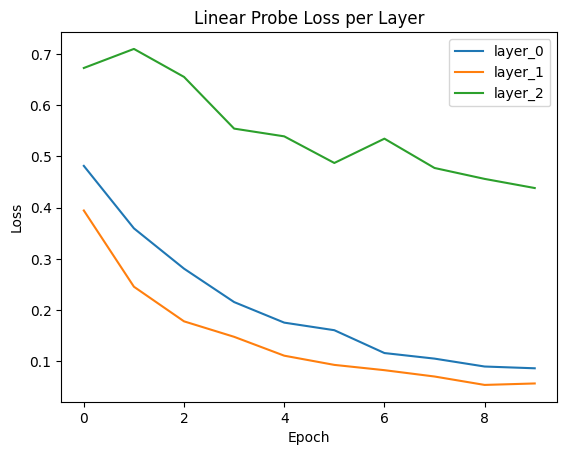

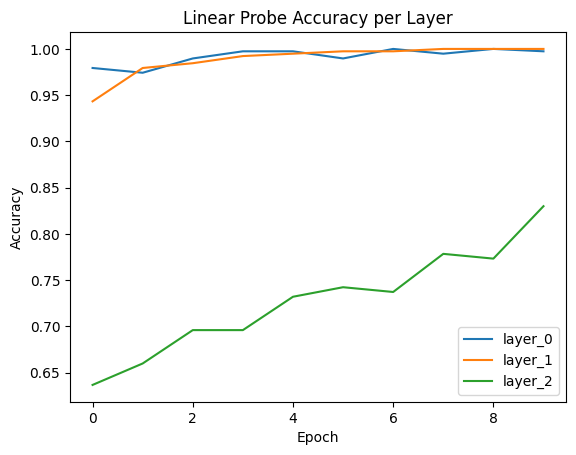

In [10]:
dataset = []

for a in range(p):
    for b in range(p):
        for x in range(2):
            for y in range(2):
                dataset.append((a,b,x,y,113))

# to numpy 
dataset = np.array(dataset)


probes, losses, accuracies = train_probes_on_residual_streams(model, dataset, num_blocks=3, epochs=10)


import matplotlib.pyplot as plt

for layer, layer_losses in losses.items():
    plt.plot(layer_losses, label=layer)
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Linear Probe Loss per Layer')
plt.show()

for layer, layer_accuracies in accuracies.items():
    plt.plot(layer_accuracies, label=layer)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Linear Probe Accuracy per Layer')
plt.show()


Quick test to check accuracy by hand

In [11]:
resid_post_activations = get_resid_post_activations(model, dataset[:1000])

probe = probes['layer_0']

i = 120
point = dataset[i]
single_activations = resid_post_activations[0][i].unsqueeze(0).to('cuda')

single_xor_bit = np.bitwise_xor(point[2], point[3])

print(torch.argmax(probe(single_activations)))
print(single_xor_bit)



tensor(0, device='cuda:0')
0


In [12]:
def get_xor_steering_vector(dataset_sample, model, block_num):

    # get xor of the dataset
    xor_bits_sample = torch.bitwise_xor(dataset_sample[:, 2], dataset_sample[:, 3])
    dataset_sample_xor0 = dataset_sample[xor_bits_sample == 0]
    dataset_sample_xor1 = dataset_sample[xor_bits_sample == 1]

    min_len = min(len(dataset_sample_xor0), len(dataset_sample_xor1))

    dataset_sample_xor0 = dataset_sample_xor0[:min_len]
    dataset_sample_xor1 = dataset_sample_xor1[:min_len]

    cache_xor0 = {}
    model.cache_all(cache_xor0)
    _ = model(dataset_sample_xor0)
    resid_activations_xor0 = cache_xor0[f'blocks.{block_num}.hook_resid_post'][:, -1]

    cache_xor1 = {}
    model.cache_all(cache_xor1)
    _ = model(dataset_sample_xor1)
    resid_activations_xor1 = cache_xor1[f'blocks.{block_num}.hook_resid_post'][:, -1]

    steering_vector = (resid_activations_xor0 - resid_activations_xor1).mean(dim=0)

    del cache_xor0
    del cache_xor1

    return steering_vector




Purpose of below cell:

- Plot the the distrobution of feature vectors learned by probes 
- Take a single data point, find feature value, also plot that on distro
- intervene on a model, input same datapoint, find feature value, plot on distro
- Find output of intervened model, check if it matches correct answer (this is what we want to move to it's own funciton, the graph is really just for sanity checking interventions)

/tmp/ipykernel_483093/3397237646.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.scatter(feature_values_point[:, 0].cpu().detach().numpy(), feature_values_point[:, 1].cpu().detach().numpy(), label=f'Single point {int(xor_bit_point.cpu().detach().numpy())}')


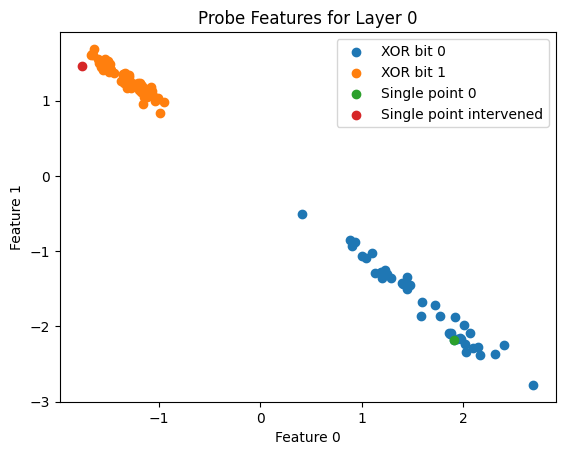

tensor([[ 26, 101,   0,   0, 113]], device='cuda:0')
xor of point: 0
correct output: 14
output of regular model: 14
output of intervened model: 14
expected output of intervened model: 15


In [13]:
import matplotlib.pyplot as plt

def probe_residual_post_during_forward_pass(model, block_num, probe, data):
    """
    function that takes a transformer, a batch of data, and a probe and 
    retruns the output of the model as well as the output of the probe (feature values)

    models passed to this function have all hooks removed after, including intervention hooks
    """
    # Initialize the cache dictionary
    cache = {}

    # Register hooks to cache the activations
    model.cache_all(cache)

    # Forward pass through the model
    output_logits = model(data)[:, -1]

    # Extracting the cached activations
    resid_post_activations = cache[f'blocks.{block_num}.hook_resid_post'][:, -1]

    feature_values = probe(resid_post_activations)

    # clear the hooks
    model.remove_all_hooks()
    del cache

    return output_logits, feature_values


layer_index = 0
single_point_index = 43
coef = 0.06
probe = probes[f'layer_{layer_index}']
feature_direction_0 = probe.linear.weight[0].detach()
feature_direction_1 = probe.linear.weight[1].detach()


# DATA INIT
dataset = []

for a in range(p):
    for b in range(p):
        for x in range(2):
            for y in range(2):
                dataset.append((a,b,x,y,113))

# to numpy
dataset = np.array(dataset)
# set seed for np
np.random.seed(0)
np.random.shuffle(dataset)
dataset_sample = torch.tensor(dataset[:100]).to('cuda')
xor_bits_sample = torch.bitwise_xor(dataset_sample[:, 2], dataset_sample[:, 3])
# steering_vector = get_xor_steering_vector(dataset_sample, model, layer_index)

single_point = dataset_sample[single_point_index].unsqueeze(0)
xor_bit_point = xor_bits_sample[single_point_index].unsqueeze(0)
correct_answer = int((single_point[0, 0] + single_point[0, 1]) % 113 + torch.bitwise_xor(single_point[0, 2], single_point[0, 3]))


# MODEL INIT
def hook_fn_probe_intervention(activations, name='hook_resid_post'):
    if xor_bit_point == 0:
        return activations - feature_direction_0 * coef + feature_direction_1 * coef
    else:
        return activations + feature_direction_0 * coef - feature_direction_1 * coef

# def hook_fn_steering_vector(activations, name='hook_resid_post'):
    # if xor_bit_point == 0:
    #     return activations - steering_vector * coef
    # else:
    #     return activations + steering_vector * coef

model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
model.load_state_dict(torch.load('transformer.pth'))

hooked_model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
hooked_model.load_state_dict(torch.load('transformer.pth'))
hooked_model.blocks[layer_index].hook_resid_post.add_hook(hook_fn_probe_intervention)


# GETTING logits and feature values

_, feature_values_sample = probe_residual_post_during_forward_pass(model, layer_index, probe, dataset_sample)
logits_regular, feature_values_point = probe_residual_post_during_forward_pass(model, layer_index, probe, single_point)
logits_intervened, feature_values_point_intervened = probe_residual_post_during_forward_pass(hooked_model, layer_index, probe, single_point)

feature_values_xor0 = feature_values_sample[xor_bits_sample == 0].cpu().detach().numpy()
feature_values_xor1 = feature_values_sample[xor_bits_sample == 1].cpu().detach().numpy()


plt.scatter(feature_values_xor0[:, 0], feature_values_xor0[:, 1], label='XOR bit 0')
plt.scatter(feature_values_xor1[:, 0], feature_values_xor1[:, 1], label='XOR bit 1')
plt.scatter(feature_values_point[:, 0].cpu().detach().numpy(), feature_values_point[:, 1].cpu().detach().numpy(), label=f'Single point {int(xor_bit_point.cpu().detach().numpy())}')
plt.scatter(feature_values_point_intervened[:, 0].cpu().detach().numpy(), feature_values_point_intervened[:, 1].cpu().detach().numpy(), label=f'Single point intervened')

plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title(f'Probe Features for Layer {layer_index}')
plt.legend()

plt.show()

print(single_point)
print(f'xor of point: {int(xor_bit_point)}')
print(f'correct output: {correct_answer}')
print(f'output of regular model: {torch.argmax(logits_regular.squeeze())}')
print(f'output of intervened model: {torch.argmax(logits_intervened.squeeze())}')
if int(xor_bit_point) == 0:
    expected_answer = correct_answer + 1
else:
    expected_answer = correct_answer - 1
print(f'expected output of intervened model: {expected_answer}')




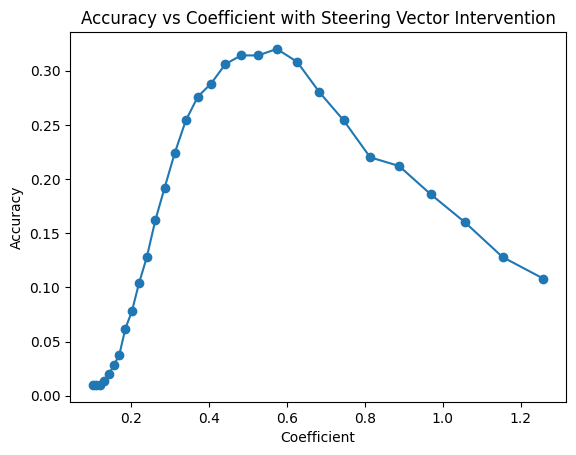

In [14]:
from typing import Union

def get_output_from_intervened_model(
    model,
    single_point,
    intervention: Union[torch.Tensor, tuple],  # either a single steering vector or a pair of feature directions
    coef,
    layer_index,
    steering_mode: str
):
    
    if steering_mode == 'probe':
        assert isinstance(intervention, tuple)
        feature_direction_0 = intervention[0]
        feature_direction_1 = intervention[1]
        def hook_fn(activations, name='hook_resid_post'):
            if xor_bit_point == 0:
                return activations - feature_direction_0 * coef + feature_direction_1 * coef
            else:
                return activations + feature_direction_0 * coef - feature_direction_1 * coef
            
    elif steering_mode == 'steering_vector':
        assert isinstance(intervention, torch.Tensor)
        steering_vector = intervention
        def hook_fn(activations, name='hook_resid_post'):
            if xor_bit_point == 0:
                return activations - steering_vector * coef
            else:
                return activations + steering_vector * coef
    else:
        raise ValueError('Invalid steering mode')
    
    xor_bit = torch.bitwise_xor(single_point[0, 2], single_point[0, 3])
    correct_answer = int((single_point[0, 0] + single_point[0, 1]) % 113 + xor_bit)

    if xor_bit == 0:
        expected_answer = correct_answer + 1
    else:
        expected_answer = correct_answer - 1

    model.blocks[layer_index].hook_resid_post.add_hook(hook_fn)

    logits = model(single_point)[:, -1]
    model.remove_all_hooks()

    return int(torch.argmax(logits.squeeze())), expected_answer



model.remove_all_hooks()

layer_index = 0
probe = probes[f'layer_{layer_index}']

dataset_sample = torch.tensor(dataset[:500]).to('cuda')

steering_vector = get_xor_steering_vector(dataset_sample, model, layer_index)
feature_direction_0 = probe.linear.weight[0].detach()
feature_direction_1 = probe.linear.weight[1].detach()

# intervention = (feature_direction_0, feature_direction_1)
intervention = steering_vector


total_points = dataset_sample.shape[0]
accuracies = []
coefs = np.logspace(-1, 0.1, 30)

# uncomment relecant interventino and change steering_mode to 'probe' or 'steering_vector'
for coef in coefs:
    count_correct = 0
    for datapoint in dataset_sample:
        intervened_prediction, expected_answer = get_output_from_intervened_model(model, datapoint.unsqueeze(0), intervention, coef, layer_index, 'steering_vector')
        if intervened_prediction == expected_answer:
            count_correct += 1
    accuracy = count_correct / total_points
    accuracies.append(accuracy)


# plot line chart with points highlighted

plt.plot(coefs, accuracies, marker='o')
plt.xlabel('Coefficient')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Coefficient with Steering Vector Intervention')
plt.show()

Ok so we can intervene with our steering vector and the probe feature direction (both yield pretty much the same vector anywayt) to predictably change model output, up to 35% of the time. That's a good sign that we're learning a relevant feature! `layer_index` can be adjusted and we see similar accuracy outputs.

Next steps:
- Investigate synergy between input and probes features, should be high!
- Test whether this is the ONLY place that the xor bit is represented by mapping these features to zero, and then 1. seeing if the model can still calculate the right output and 2. seeing if another linear probe can predict the xor value from from the activations after we zero out these activations 
- Improving the language model? Currently the config is a bit hodge podge and randomly chosen eg 3 layers, however many epochs etc. Perhaps we could increase result quality by training the transformer better?

I think I will go with 2 then 1 then maybe 3 in a bit. 1 and 2 are currently most interesting.

for 2., during a forward pass we simply project activations onto feature directions, then subtract the projection from the activations. We then want repeat past experiments with this hooked model

In [15]:
import copy

lt.monkey_patch()


def add_zeroed_linear_xor_rep_hooks(
    model: Transformer,
    block_num: int,
    probe: LinearProbe
):
    """
    Function that returns a model, removes its hooks, and zeros out the linear representation of the xor feature
    Which the probe is presumed to have learned.

    Used for eg to check if there are any other linear representations of the xor feature in the model
    """
    model.remove_all_hooks()

    feature_direction_0 = probe.linear.weight[0].detach()
    feature_direction_1 = probe.linear.weight[1].detach()
    normed_feature_direction_0 = feature_direction_0 / torch.norm(feature_direction_0)
    normed_feature_direction_1 = feature_direction_1 / torch.norm(feature_direction_1)


    def hook_remove_xor_linear_rep(activations, name='remove_linear_xor_rep'):

        dot_products_0 = torch.einsum('b c d, d -> b c', activations, normed_feature_direction_0)
        proj_act_onto_f0 = torch.einsum('b c, d -> b c d', dot_products_0, normed_feature_direction_0)
        act_without_f0 = activations - proj_act_onto_f0

        dot_products_1 = torch.einsum('b c d, d -> b c', act_without_f0, normed_feature_direction_1)
        diff1 = torch.einsum('b c, d -> b c d', dot_products_1, normed_feature_direction_1)
        act_without_f0_and_f1 = act_without_f0 - diff1

        assert torch.allclose(torch.einsum('b c d, d -> b c', act_without_f0_and_f1, normed_feature_direction_1), torch.zeros_like(dot_products_1), atol=1e-5), 'Linear representation of XOR bit 1 not zeroed'
        assert torch.allclose(torch.einsum('b c d, d -> b c', act_without_f0_and_f1, normed_feature_direction_1), torch.zeros_like(dot_products_1), atol=1e-5), 'Linear representation of XOR bit 1 not zeroed'

        return act_without_f0_and_f1

    model.blocks[block_num].hook_resid_post.add_hook(hook_remove_xor_linear_rep)

    return model



zeroed_model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
zeroed_model.load_state_dict(torch.load('transformer.pth'))
layer_index = 0
probe = probes[f'layer_{layer_index}']
zeroed_model = add_zeroed_linear_xor_rep_hooks(zeroed_model, layer_index, probe)
dataset_sample = dataset[:500]

print(f'accuracy of regular transformer: {100 * float(test_model_accuracy(zeroed_model, dataset_sample)): .1f}%')

regular_model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
regular_model.load_state_dict(torch.load('transformer.pth'))

print(f'accuracy of zeroed out transformer: {100 * float(test_model_accuracy(regular_model, dataset_sample)): .1f}%')

probes_A, losses_A, accuracies_A = train_probes_on_residual_streams(regular_model, dataset, num_blocks=3, epochs=10)
probes_B, losses_B, accuracies_B = train_probes_on_residual_streams(zeroed_model, dataset, num_blocks=3, epochs=10)



accuracy of regular transformer:  84.8%
accuracy of zeroed out transformer:  99.0%


Find the dot product of the two feature vectors learned by the probe, this is expected to be -1 because they should just be opposites

In [16]:
# layer_index = 0
# probe = probes[f'layer_{layer_index}']


# feature_direction_0 = probe.linear.weight[0].detach()
# feature_direction_1 = probe.linear.weight[1].detach()

# normed_feature_direction_0 = feature_direction_0 / torch.norm(feature_direction_0)
# normed_feature_direction_1 = feature_direction_1 / torch.norm(feature_direction_1)

# print(torch.dot(normed_feature_direction_0, normed_feature_direction_1))


Lets verify our zeroing intervention and test whether or not the secondary learned linear features are meaningful

Prediction: if two input variables have synergy with the output then they should also have synergy with some intermediate feature in some downstream layer

In [15]:
accuracies_regular_probe_on_regular_model = test_probes_on_residual_streams(regular_model, probes_A, dataset[:500])

print(f'Regular probe {layer_index} accuracy on regular model: {100 * accuracies_regular_probe_on_regular_model[f"layer_{layer_index}"]: .1f}%')

accuracies_regular_probe_on_zeroed_model = test_probes_on_residual_streams(zeroed_model, probes_A, dataset[:500])

print(f'Regular probe {layer_index} accuracy on zeroed model: {100 * accuracies_regular_probe_on_zeroed_model[f"layer_{layer_index}"]: .1f}%')

accuracies_zeroed_probe_on_regular_model = test_probes_on_residual_streams(regular_model, probes_B, dataset[:500])

print(f'Zeroed probe {layer_index} accuracy on regular model: {100 * accuracies_zeroed_probe_on_regular_model[f"layer_{layer_index}"]: .1f}%')

accuracies_zeroed_probe_on_zeroed_model = test_probes_on_residual_streams(zeroed_model, probes_B, dataset[:500])

print(f'Zeroed probe {layer_index} accuracy on zeroed model: {100 * accuracies_zeroed_probe_on_zeroed_model[f"layer_{layer_index}"]: .1f}%')




Regular probe 0 accuracy on regular model:  99.6%
Regular probe 0 accuracy on zeroed model:  52.8%
Zeroed probe 0 accuracy on regular model:  95.6%
Zeroed probe 0 accuracy on zeroed model:  98.4%


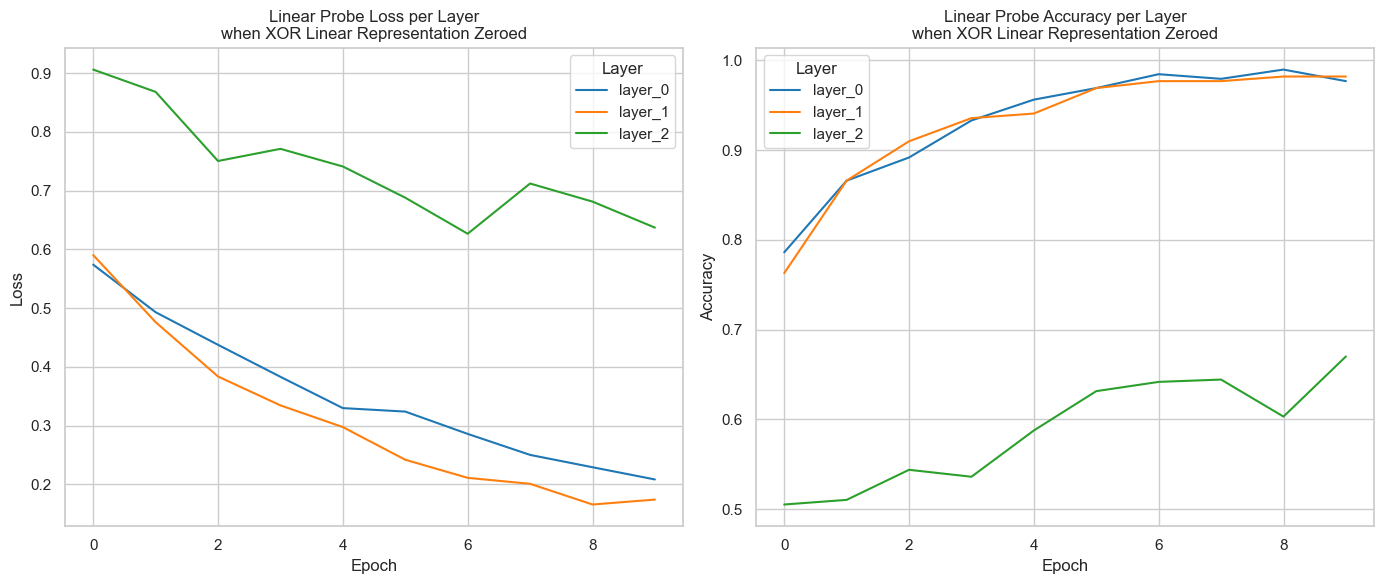

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the losses
for idx, (layer, layer_losses_B) in enumerate(losses_B.items()):
    ax1.plot(layer_losses_B, label=layer, color=color_palette[idx % len(color_palette)])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(title="Layer")
ax1.set_title('Linear Probe Loss per Layer\nwhen XOR Linear Representation Zeroed')

# Plot the accuracies
for idx, (layer, layer_accuracies_B) in enumerate(accuracies_B.items()):
    ax2.plot(layer_accuracies_B, label=layer, color=color_palette[idx % len(color_palette)])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(title="Layer")
ax2.set_title('Linear Probe Accuracy per Layer\nwhen XOR Linear Representation Zeroed')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [19]:
model_1 = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
model_1.load_state_dict(torch.load('transformer.pth'))

model_2 = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln).to('cuda')
model_2.load_state_dict(torch.load('transformer.pth'))

probes_1, losses_1, accuracies_1 = train_probes_on_residual_streams(model_1, dataset, num_blocks=3, epochs=10)
probes_2, losses_2, accuracies_2 = train_probes_on_residual_streams(model_2, dataset, num_blocks=3, epochs=10)

probe_1_0 = probes_1['layer_0']
probe_2_0 = probes_2['layer_0']

feature_1 = probe_1_0.linear.weight[0].detach()
feature_2 = probe_2_0.linear.weight[0].detach()

normed_feature_1 = feature_1 / torch.norm(feature_1)
normed_feature_2 = feature_2 / torch.norm(feature_2)

dot_product = torch.dot(normed_feature_1, normed_feature_2)

print(f'dot product between differently intialized probes: {float(dot_product): .2f}')

dot product between differently intialized probes:  0.99


seems like there is a high inductive bias for these probes, and yet there exists other linear reps of the xor bit. Interesting!!!

Seems like I am somewhat losing focus though. Lets summarize and move on.

Turns out that zeroing the xor features learned does not actually kill model performance (goes down to 86%) and this is probably because there are multiple linear reps of the xor bit, wonder if intervening on them both (or all of them if there are more) would increase performance lol but ok fine let's leave this because I don't want to become hyperfocused on this toy model. 

Hypothesis: in overparameterized regime multiple redundant linear features are learned.

Lets leave it at that, I could go down a rabbit hole with this model but won't, answering these questions would not actually be that interesting since I doubt the lessons extend to larger model. Although I do have an experiment now thoughL

Experiment: On language models, or other non-overparameterized models, can you still zero out a feature and learn another linear rep of something? Like if you can probe for deception_yes/deception_no, then zero those directions, can you learn another pair of similar features?

Experiment: Train an SAE on a transformer that does next-step-prediction of the ECOG data, then check the features (or maybe even neurons) for emergence (probably using JIDT). The challenge with represenation learning of emergent features is that Psi is hard to optomize for directly, hard to think of other ways to learn emergent features, but emergent features SHOULD be useful for predicting the next step. So they should be in NTP models. Perhaps just train one then crack it open and inspect. Or perhaps one could train an adjusted transformer to learn an intermedate layer that is sparse. Issue is unsure if NTP with transformers is sample efficient enough to learn good features on small datasets. Only one way to find out! (also if there are more useful features than datapoints you're toast because you can just learn a feature for each datapoint easier than learning the features)

Next steps:
- Try out JIDT on the learned feature lol, prove that synergystic feature was found and get to know to library a lil bit 
- Improve the above model and understand it better (probably won't)
- Train a damn SAE (should probably do this eventually lol)
- Find synergystic features WRT to other downstream features and show that with ACDC (automated circuit discovery) the upstream synergstic feautures are part of the circuit that calculates that feature. (This is more like an experiment to run later on bigger, more interesting models).

Meta idea: Before running an experiment, ask myself would I care if this was true or false? What would this imply I should do next? I think the issue with many above experiments is that they are on a small shitty overparameterized model so I can't really conclude much from my findings. Don't regret this though, I've had fun and feel more confident.

In any case, I think moving onto another notebook and a bigger model is warented o7, after getting a cheeky SAE working on this shit.




